# Netflix Dataset Recommender System: Item-Based Collaborative Filtering

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from math import sqrt
from sklearn.neighbors import NearestNeighbors


In [101]:
# Load Data
movies = pd.read_csv('Netflix_Merged.csv')

## Data Cleaning

### Inspecting Data

In [102]:
print(movies.head())

   movieId   userId  rating  MovieAge                   title  release_year  \
0       30  2173336       5         1  Something's Gotta Give          2003   
1       30  2473170       5         1  Something's Gotta Give          2003   
2       30   900816       3         2  Something's Gotta Give          2003   
3       30  1990901       4         1  Something's Gotta Give          2003   
4       30   662337       4         2  Something's Gotta Give          2003   

                      genres_list                genres  
0  ['drama', 'comedy', 'romance']  drama|comedy|romance  
1  ['drama', 'comedy', 'romance']  drama|comedy|romance  
2  ['drama', 'comedy', 'romance']  drama|comedy|romance  
3  ['drama', 'comedy', 'romance']  drama|comedy|romance  
4  ['drama', 'comedy', 'romance']  drama|comedy|romance  


In [104]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985736 entries, 0 to 985735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movieId       985736 non-null  int64 
 1   userId        985736 non-null  int64 
 2   rating        985736 non-null  int64 
 3   MovieAge      985736 non-null  int64 
 4   title         985736 non-null  object
 5   release_year  985736 non-null  int64 
 6   genres_list   985736 non-null  object
 7   genres        985736 non-null  object
dtypes: int64(5), object(3)
memory usage: 60.2+ MB


In [105]:
# Check for missing values (NaN or null values)
print(movies.isnull().sum())

movieId         0
userId          0
rating          0
MovieAge        0
title           0
release_year    0
genres_list     0
genres          0
dtype: int64


In [106]:
# Printing the head of the DataFrame to verify the changes
print(movies.head())

   movieId   userId  rating  MovieAge                   title  release_year  \
0       30  2173336       5         1  Something's Gotta Give          2003   
1       30  2473170       5         1  Something's Gotta Give          2003   
2       30   900816       3         2  Something's Gotta Give          2003   
3       30  1990901       4         1  Something's Gotta Give          2003   
4       30   662337       4         2  Something's Gotta Give          2003   

                      genres_list                genres  
0  ['drama', 'comedy', 'romance']  drama|comedy|romance  
1  ['drama', 'comedy', 'romance']  drama|comedy|romance  
2  ['drama', 'comedy', 'romance']  drama|comedy|romance  
3  ['drama', 'comedy', 'romance']  drama|comedy|romance  
4  ['drama', 'comedy', 'romance']  drama|comedy|romance  


In [107]:
df = movies
df.head()

,movieId,userId,rating,MovieAge,title,release_year,genres_list,genres
0,30,2173336,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
1,30,2473170,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
2,30,900816,3,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
3,30,1990901,4,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
4,30,662337,4,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985736 entries, 0 to 985735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movieId       985736 non-null  int64 
 1   userId        985736 non-null  int64 
 2   rating        985736 non-null  int64 
 3   MovieAge      985736 non-null  int64 
 4   title         985736 non-null  object
 5   release_year  985736 non-null  int64 
 6   genres_list   985736 non-null  object
 7   genres        985736 non-null  object
dtypes: int64(5), object(3)
memory usage: 60.2+ MB


In [109]:
df.isnull().sum()

movieId         0
userId          0
rating          0
MovieAge        0
title           0
release_year    0
genres_list     0
genres          0
dtype: int64

### Drop Unused Columns

In [110]:
# df.drop(columns=['Date','YearOfRelease', 'RatingYear'], inplace=True)

# # Printing the head of the DataFrame to verify the changes
# print(df.head())


In [111]:
df.head()

,movieId,userId,rating,MovieAge,title,release_year,genres_list,genres
0,30,2173336,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
1,30,2473170,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
2,30,900816,3,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
3,30,1990901,4,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
4,30,662337,4,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance


## EDA

### Descriptive Statistics

In [112]:
df.describe()

,movieId,userId,rating,MovieAge,release_year
count,985736.000000,9.857360e+05,985736.000000,985736.000000,985736.000000
mean,2303.831052,1.321097e+06,3.540002,6.083509,2004.099171
std,1646.463156,7.646990e+05,1.015997,9.890038,7.658595
min,30.000000,6.000000e+00,1.000000,0.000000,1980.000000
25%,758.000000,6.594600e+05,3.000000,1.000000,2002.000000
50%,2112.000000,1.316412e+06,4.000000,2.000000,2003.000000
75%,4356.000000,1.982572e+06,4.000000,6.000000,2004.000000
max,4482.000000,2.649429e+06,5.000000,81.000000,2022.000000


In [113]:
# Understanding the data
df.describe(include='all')

,movieId,userId,rating,MovieAge,title,release_year,genres_list,genres
count,985736.000000,9.857360e+05,985736.000000,985736.000000,985736,985736.000000,985736,985736
unique,NaN,NaN,NaN,NaN,69,NaN,59,59
top,NaN,NaN,NaN,NaN,Something's Gotta Give,NaN,"['drama', 'comedy', 'romance']",drama|comedy|romance
freq,NaN,NaN,NaN,NaN,118413,NaN,219531,219531
mean,2303.831052,1.321097e+06,3.540002,6.083509,NaN,2004.099171,NaN,NaN
std,1646.463156,7.646990e+05,1.015997,9.890038,NaN,7.658595,NaN,NaN
min,30.000000,6.000000e+00,1.000000,0.000000,NaN,1980.000000,NaN,NaN
25%,758.000000,6.594600e+05,3.000000,1.000000,NaN,2002.000000,NaN,NaN
50%,2112.000000,1.316412e+06,4.000000,2.000000,NaN,2003.000000,NaN,NaN
75%,4356.000000,1.982572e+06,4.000000,6.000000,NaN,2004.000000,NaN,NaN


### Visualizing the Distribution

#### Normality Check

In [114]:
# Perform Anderson-Darling test on 'rating' column
anderson_test = stats.anderson(df['rating'], dist='norm')
print(f"Anderson-Darling Test statistic: {anderson_test.statistic}, critical values: {anderson_test.critical_values}")

# Interpretation of the output
if anderson_test.statistic > max(anderson_test.critical_values):
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data might be normal.")


Anderson-Darling Test statistic: 42572.1862005298, critical values: [0.576 0.656 0.787 0.918 1.092]
Reject null hypothesis: Data is not normally distributed.


#### Histogram

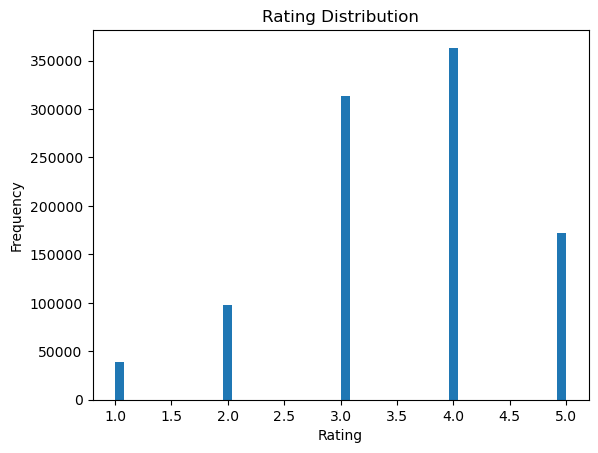

In [115]:
plt.hist(df['rating'], bins=50)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Boxplot

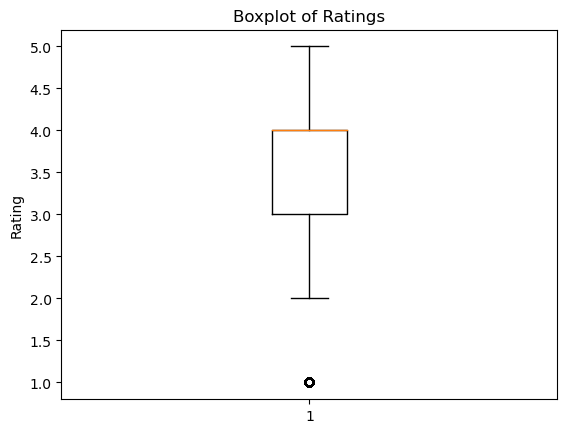

In [116]:
plt.boxplot(df['rating'])
plt.title('Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()


* **Spread of Ratings:** The box extends from a rating of 3 to a rating of 4. 
* **Median Rating:** The line in the middle of the box is at a rating of 4. 
* **Outliers:** The whiskers extend to a rating of 1 at the bottom and a rating of 5 at the top. There are no data points beyond the whiskers, so there aren't any outliers in this data set.


#### Correlation Matrix

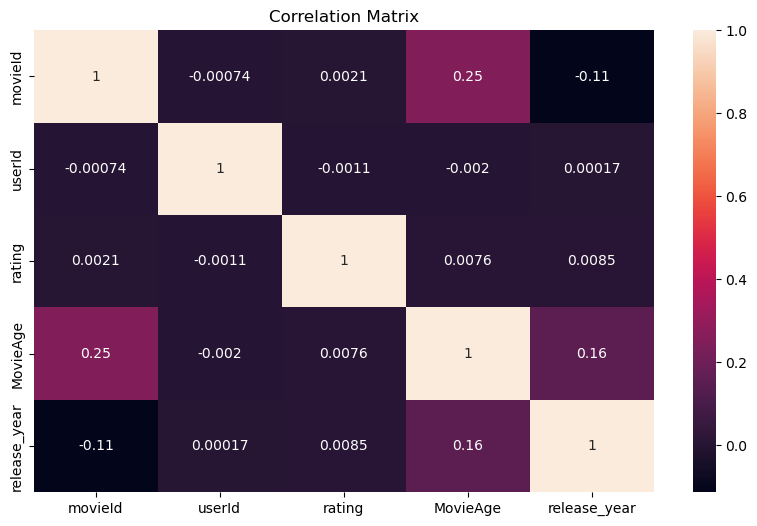

In [117]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()


- Movie Release Year and Movie Age: This is a perfect positive correlation of 1. This is expected because movie age is calculated directly from release year.
- Movie Release Year and Rating: There appears to be a very weak negative correlation of approximately -0.11. This is so weak that it may not be statistically significant. It suggests a slight tendency for older movies (with lower release years) to have slightly higher ratings.
- Movie Release Year and User ID: There appears to be a very weak negative correlation of approximately -0.001. This is so close to zero that it's likely there is no real correlation between release year and user IDs.
- Movie Release Year and Movie ID: There appears to be a very weak positive correlation of approximately 0.002. This is so close to zero that it's likely there is no real correlation between release year and movie IDs.
- Movie Age and Rating: There appears to be a very weak negative correlation of approximately -0.11. This is the same correlation we saw between release year and rating, and for the same reason. It suggests a slight tendency for older movies to have slightly higher ratings.
- Movie Age and User ID: There appears to be a very weak negative correlation of approximately -0.001. This is so close to zero that it's likely there is no real correlation between movie age and user IDs.
- Movie Age and Movie ID: There appears to be a very weak positive correlation of approximately 0.002. This is so close to zero that it's likely there is no real correlation between movie age and movie IDs.
- Rating and User ID: There appears to be a very weak positive correlation of approximately 0.002. This is so close to zero that it's likely there is no real correlation between ratings and user IDs.
- Rating and Movie ID: There appears to be a weak positive correlation of approximately 0.25. This suggests that there might be a slight tendency for movies with higher IDs to have higher ratings. However, the correlation is weak, so it may not be statistically significant.
- User ID and Movie ID: There appears to be a very weak negative correlation of approximately -0.0007. This is so close to zero that it's likely there is no real correlation between user IDs and movie IDs.

#### Data Distribution

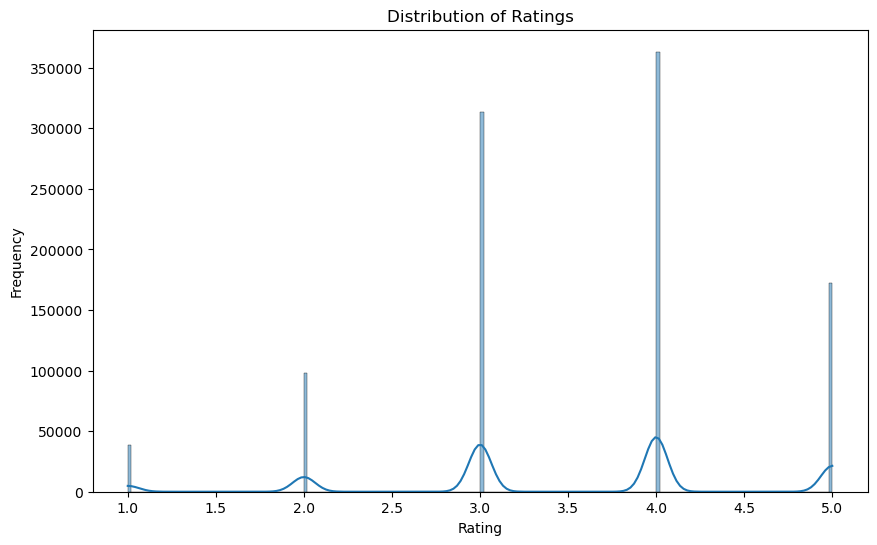

In [118]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()



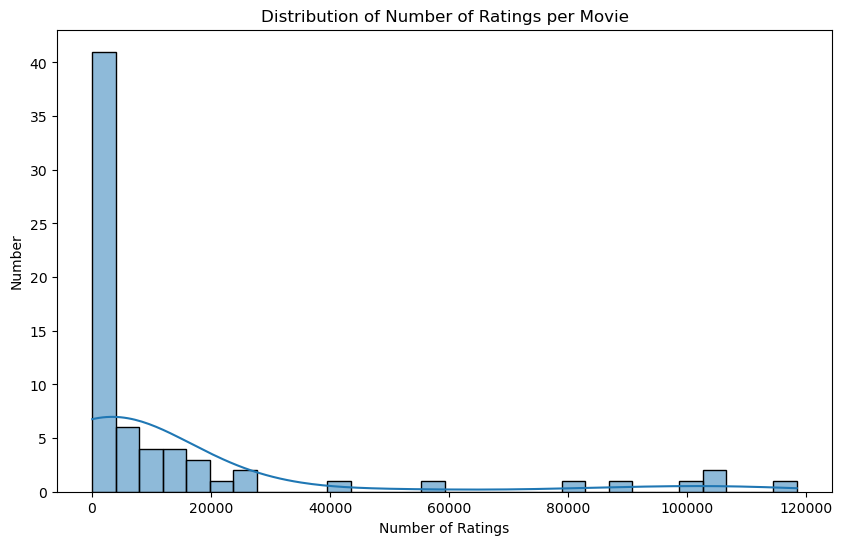

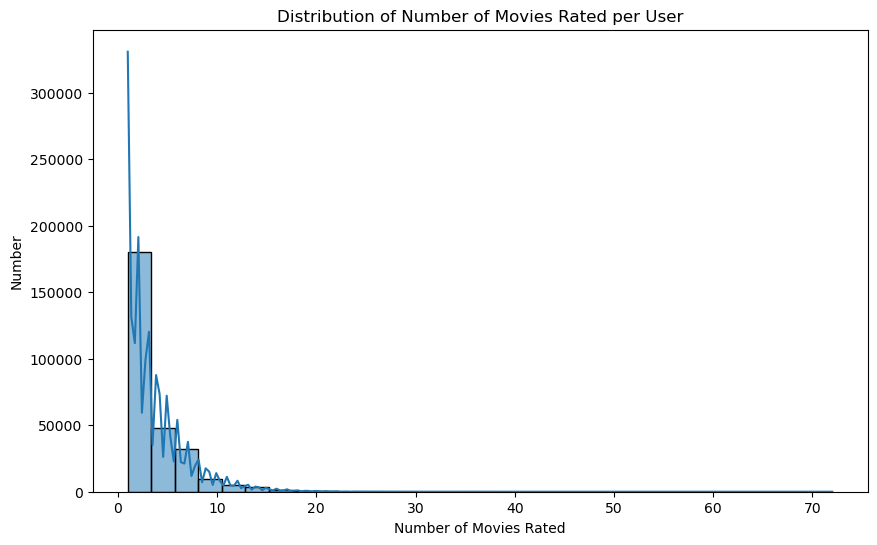

In [119]:
# Distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('movieId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number')
plt.show()

# Distribution of the number of movies rated per user
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('userId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number')
plt.show()


The graph is a right-skewed distribution. This means that there are more users who have rated a small number of movies than users who have rated a large number of movies. The tail of the distribution extends further to the right, indicating a larger number of users who have only rated a few movies.


The x-axis doesn't start at zero that means there are no users who haven't rated any movies included in this data set.
There is a peak around the 20-30 movie range, which suggests that this is the most common number of movies rated by users in this data set.

In [120]:
# Correlation between 'rating' and 'MovieAge'
spearman_corr, spearman_p_value = spearmanr(df['rating'], df['MovieAge'])
print(f"Spearman's Correlation Coefficient: {spearman_corr}, P-value: {spearman_p_value}")

# Interpretation of Spearman's correlation
if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a statistically significant positive correlation between 'rating' and 'MovieAge'.")
    elif spearman_corr < 0:
        print("There is a statistically significant negative correlation between 'rating' and 'MovieAge'.")
    else:
        print("There is a statistically significant but no linear correlation between 'rating' and 'MovieAge'.")
else:
    print("There is no statistically significant correlation between 'rating' and 'MovieAge'.")


Spearman's Correlation Coefficient: -0.02198486157689448, P-value: 1.2012362141280476e-105
There is a statistically significant negative correlation between 'rating' and 'MovieAge'.


In [121]:
df.head()

,movieId,userId,rating,MovieAge,title,release_year,genres_list,genres
0,30,2173336,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
1,30,2473170,5,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
2,30,900816,3,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
3,30,1990901,4,1,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance
4,30,662337,4,2,Something's Gotta Give,2003,"['drama', 'comedy', 'romance']",drama|comedy|romance


### Encoding Categorical Variables

In [122]:
# Extract genres and perform one-hot encoding
df_genres = movies.set_index('movieId')['genres'].str.get_dummies(sep='|')

### Creating New Features

In [123]:
# Extracting the number of genres per movie as a new feature
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

## Model Implementation

### Data Preparation

In [124]:
# One-hot encode genres
df['genres_list'] = df['genres'].str.split('|') #Splits the 'genres' column into lists of genres.

#explodes the lists in the 'genres_list' column into separate rows.
#Then it converts the categorical variable into dummy variables and groups the dummy variables
genres_encoded = df['genres_list'].explode().str.get_dummies().groupby(level=0).sum()


### Creating Interaction Features

In [125]:
# Initialize a list to collect the new interaction DataFrames
interaction_columns = []

# Generate interaction features by multiplying pairs of one-hot encoded genre columns together
genre_columns = genres_encoded.columns
for i in range(len(genre_columns)):
    for j in range(i+1, len(genre_columns)):
        interaction_feature_name = f"{genre_columns[i]}_{genre_columns[j]}"
        # Instead of inserting each column into the DataFrame, store it in the list
        interaction_columns.append(genres_encoded[genre_columns[i]] * genres_encoded[genre_columns[j]].rename(interaction_feature_name))

# Concatenate all interaction columns at once before concatenating with the original DataFrame
interaction_features = pd.concat(interaction_columns, axis=1)
genres_encoded = pd.concat([genres_encoded, interaction_features], axis=1)


In [126]:
df.head()

,movieId,userId,rating,MovieAge,title,release_year,genres_list,genres,num_genres
0,30,2173336,5,1,Something's Gotta Give,2003,"[drama, comedy, romance]",drama|comedy|romance,3
1,30,2473170,5,1,Something's Gotta Give,2003,"[drama, comedy, romance]",drama|comedy|romance,3
2,30,900816,3,2,Something's Gotta Give,2003,"[drama, comedy, romance]",drama|comedy|romance,3
3,30,1990901,4,1,Something's Gotta Give,2003,"[drama, comedy, romance]",drama|comedy|romance,3
4,30,662337,4,2,Something's Gotta Give,2003,"[drama, comedy, romance]",drama|comedy|romance,3


### Calculate Genre Popularity

In [127]:
# Calculate genre popularity as the sum of movies in each genre
genre_popularity = genres_encoded.sum(axis=0).sort_values(ascending=False)

# Normalize genre popularity to get a score between 0 and 1
genre_popularity = genre_popularity / genre_popularity.max()


### Calculate Genre Rarity

In [128]:
# Calculate genre rarity as the inverse of popularity
genre_rarity = 1 - genre_popularity

#### Add Popularity and Rarity Scores to Each Movie

In [129]:
# For each movie, calculate an average popularity score based on its genres
df['genre_popularity_score'] = genres_encoded.dot(genre_popularity) / df['num_genres']

# Similarly, calculate an average rarity score
df['genre_rarity_score'] = genres_encoded.dot(genre_rarity) / df['num_genres']

#### Add Popularity and Rarity Scores to Each Movie

In [130]:
# For each movie, calculate an average popularity score based on its genres
df['genre_popularity_score'] = genres_encoded.dot(genre_popularity) / df['num_genres']

# Similarly, calculate an average rarity score
df['genre_rarity_score'] = genres_encoded.dot(genre_rarity) / df['num_genres']

### Integration

In [131]:
# Calculate genre popularity and rarity
genre_popularity = genres_encoded.sum(axis=0).sort_values(ascending=False)
genre_popularity = genre_popularity / genre_popularity.max()  # Normalize
genre_rarity = 1 - genre_popularity  # Calculate rarity as inverse of popularity

# Add average popularity and rarity scores for each movie's genres
df['genre_popularity_score'] = genres_encoded.dot(genre_popularity) / df['num_genres']
df['genre_rarity_score'] = genres_encoded.dot(genre_rarity) / df['num_genres']


In [163]:
sample_df = df.sample(frac=0.1, random_state=42)  # Taking 10% of the DataFrame as a sample

In [164]:
# Splitting the dataset into training (60%), validation (20%), and testing (20%) sets
train, temp = train_test_split(sample_df, test_size=0.4, random_state=42)  # 60% train, 40% temp
validation, test = train_test_split(temp, test_size=0.5, random_state=42)  # Split temp into 50% validation, 50% test

In [165]:
train = train.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Prepare data for similarity computation for item similarity based on user ratings (User-Item Matrix)
pivot_table_train = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [166]:
pivot_table_train.head()

movieId,30,242,252,258,275,285,349,372,414,570,...,3708,3753,4283,4334,4356,4402,4404,4472,4479,4482
userId,,,,,,,,,,,,,,,,,,,,,
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
183,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
266,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# Ensure train DataFrame has 'movieId' as index or use it for filtering directly
train_indexed = train.set_index('movieId')

# Find common movieIds between genres_encoded and train
# This ensures that only movies present in both datasets are considered for similarity computation.
common_movieIds = genres_encoded.index.intersection(train_indexed.index)

# Filter genres_encoded to include only common movieIds
# This ensures that we're only considering genres encoded information for movies that have ratings data available.
genres_encoded_train = genres_encoded.loc[common_movieIds]


### Similarity Calculation

In [168]:
####### COSINE Calculations
# Compute item similarity matrix based on ratings
item_similarity_cosine = cosine_similarity(pivot_table_train.T) # pivot_table_train.T = Transposed pivot_table_train matrix
item_similarity_df_cosine = pd.DataFrame(item_similarity_cosine, index=pivot_table_train.columns, columns=pivot_table_train.columns)

# Proceed with the similarity computation
genre_similarity_cosine = cosine_similarity(genres_encoded_train)
genre_similarity_df_cosine = pd.DataFrame(genre_similarity_cosine, index=common_movieIds, columns=common_movieIds)

# Normalize and combine the similarity matrices using min-max normalization
item_similarity_df_cosine = (item_similarity_df_cosine - item_similarity_df_cosine.min()) / (item_similarity_df_cosine.max() - item_similarity_df_cosine.min())
genre_similarity_df_cosine = (genre_similarity_df_cosine - genre_similarity_df_cosine.min()) / (genre_similarity_df_cosine.max() - genre_similarity_df_cosine.min())
combined_similarity_df_cosine = (item_similarity_df_cosine + genre_similarity_df_cosine) / 2



### Prediction Function

It first checks if the given item_id exists in the columns of the similarity_matrix and if the user_id exists in the index of the user_item_matrix. If not, it returns NaN as the prediction.

It retrieves the top k most similar items to the target item_id from the similarity_matrix.

It then retrieves the user's ratings for these similar items from the user_item_matrix, ensuring only valid ratings are considered.

It calculates the weighted average of the user's ratings for the common items based on their similarities. If there are no common items with positive similarity scores, it returns NaN as the prediction.

If the prediction is NaN, it uses user and item biases as fallbacks. It retrieves the user's average rating from the user_bias dictionary, the item's average rating from the item_bias dictionary, and calculates the prediction as the average of these two biases.

If the item_id doesn't exist in the columns of the similarity_matrix or the user_id doesn't exist in the index of the user_item_matrix, it returns NaN as the prediction.

In [169]:

def predict_rating(user_id, item_id, k, user_item_matrix, similarity_matrix, global_avg, user_bias, item_bias):
    if item_id in similarity_matrix.columns and user_id in user_item_matrix.index:
        # Get top k similar items
        neighbors = similarity_matrix[item_id].drop(item_id).sort_values(ascending=False).head(k)
        user_ratings = user_item_matrix.loc[user_id, neighbors.index].dropna()
        common = neighbors.loc[user_ratings.index]
        
        # Weighted average of top k similar items' ratings
        if common.sum() > 0:
            weighted_sum = np.dot(common, user_ratings)
            prediction = weighted_sum / common.sum()
        else:
            prediction = np.nan
            
        # If prediction is nan, use user and item bias as fallback
        if np.isnan(prediction):
            user_avg = user_bias.get(user_id, global_avg)
            item_avg = item_bias.get(item_id, global_avg)
            prediction = (user_avg + item_avg) / 2
    else:
        prediction = np.nan
    return prediction


### Error Calculation Function

In [170]:
def compute_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


### Some Calculations

This part calculates the global average rating, providing a baseline for comparisons across users and items. Subsequently, it derives user biases by analyzing each user's average rating relative to the global average, revealing individual rating tendencies. Similarly, it computes item biases by assessing how each item's average rating deviates from the global average, indicating item-specific preferences or characteristics.

In [171]:
# Calculate the global average rating
global_avg = train['rating'].mean()

# Calculate user biases
user_avg_ratings = train.groupby('userId')['rating'].mean()
user_bias = user_avg_ratings - global_avg

# Calculate item biases
item_avg_ratings = train.groupby('movieId')['rating'].mean()
item_bias = item_avg_ratings - global_avg


### Hyperparameter Tunning


1. **Tune `k` using Validation Set:**
   - The `tune_k_using_validation` function iterates over each `k` value from a specified range (`k_values`).
   - For each `k`, it predicts ratings for user-item pairs in the validation dataset using the `predict_rating` function.
   - It calculates the RMSE for each prediction and stores the average RMSE for each `k`.
   - Finally, it selects the `k` value with the lowest average RMSE as the best `k`.

2. **Cross-validation with Tuned `k`:**
   - The `cross_validate` function performs k-fold cross-validation on the training data.
   - For each fold, it tunes the `k` value using the validation set and `tune_k_using_validation`.
   - It calculates the average RMSE for each `k` across all folds and selects the `k` value with the lowest overall average RMSE as the best `k`.

3. **Print Results**



In [172]:
def tune_k_using_validation(validation_data, k_values):
    rmse_scores = {}
    for k in k_values:
        # Initialize list to store individual RMSE scores for this value of k
        k_rmse_scores = []
        # Iterate over each user-item pair in the validation dataset
        for index, row in validation_data.iterrows():
            user_id = row['userId']
            item_id = row['movieId']
            actual_rating = row['rating']
            # Inside tune_k_using_validation function
            predicted_rating = predict_rating(user_id, item_id, k, pivot_table_train, combined_similarity_df_cosine, global_avg, user_bias, item_bias)

            # Only calculate RMSE for non-NaN predictions
            if not np.isnan(predicted_rating):
                k_rmse_scores.append(compute_rmse([actual_rating], [predicted_rating]))
        # Compute average RMSE for this k value, if there were any predictions
        if k_rmse_scores:
            avg_rmse = np.mean(k_rmse_scores)
            rmse_scores[k] = avg_rmse
            print(f'RMSE for k={k}: {avg_rmse:.4f}')  # Print RMSE for each k value

    # Find the k value with the lowest average RMSE
    best_k = min(rmse_scores, key=rmse_scores.get)
    return best_k, rmse_scores

# Modify the cross_validate function to use tune_k_using_validation
def cross_validate(train_data, k_values, global_avg, user_bias, item_bias, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_k = None
    best_rmse = float('inf')
    overall_rmse_scores = {}  # To store average RMSE for each k across all folds

    for k in k_values:
        rmse_scores = []
        for train_index, val_index in kf.split(train_data):
            train_fold = train_data.iloc[train_index]
            val_fold = train_data.iloc[val_index]
            # Directly store the best k and its RMSE for this fold
            k, _ = tune_k_using_validation(val_fold, [k])
            rmse_scores.append(_[k])
        avg_rmse = np.mean(rmse_scores)
        overall_rmse_scores[k] = avg_rmse  # Store the average RMSE for this k

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_k = k

# Print RMSE for each k after all folds
    for k, rmse in overall_rmse_scores.items():
        print(f'Overall average RMSE for k={k}: {rmse:.4f}')
    return best_k

# Define a range of k values to search through
k_values = range(2, 6)

# Assuming you have a validation set to test with, you can now find the best k
best_k = cross_validate(train, k_values, global_avg, user_bias, item_bias)
print(f'Best k found through cross-validation: {best_k}')


RMSE for k=2: 3.5339
RMSE for k=2: 3.5417
RMSE for k=2: 3.5362
RMSE for k=3: 3.5339
RMSE for k=3: 3.5417
RMSE for k=3: 3.5362
RMSE for k=4: 3.5339
RMSE for k=4: 3.5417
RMSE for k=4: 3.5362
RMSE for k=5: 3.5339
RMSE for k=5: 3.5417
RMSE for k=5: 3.5362
Overall average RMSE for k=2: 3.5373
Overall average RMSE for k=3: 3.5373
Overall average RMSE for k=4: 3.5373
Overall average RMSE for k=5: 3.5373
Best k found through cross-validation: 2


### Train Model Function

In [178]:
def train_model(train_data, best_k, similarity_matrix, global_avg, user_bias, item_bias):
    predictions = []
    actuals = []
    for index, row in train_data.iterrows():
        pred = predict_rating(row['userId'], row['movieId'], best_k, pivot_table_train, similarity_matrix, global_avg, user_bias, item_bias)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(row['rating'])
    # Compute RMSE for the training set
    train_rmse = compute_rmse(actuals, predictions)
    print(f'Training RMSE: {train_rmse}')
    return train_rmse

train_rmse = train_model(train, best_k, combined_similarity_df_cosine, global_avg, user_bias, item_bias)


Training RMSE: 3.5829386245182095


### Evaluation on the Test Set

In [174]:
# Now evaluate the model on the test set, including global_avg, user_bias, and item_bias in predict_rating
test_predictions = [predict_rating(row['userId'], row['movieId'], best_k, pivot_table_train, combined_similarity_df_cosine, global_avg, user_bias, item_bias) for index, row in test.iterrows()]
test_actual = test['rating'].tolist()

# Filter out NaN predictions
test_predictions_filtered = [pred for pred, actual in zip(test_predictions, test_actual) if not np.isnan(pred)]
test_actual_filtered = [actual for pred, actual in zip(test_predictions, test_actual) if not np.isnan(pred)]

# Compute RMSE for the test set
test_rmse = compute_rmse(test_actual_filtered, test_predictions_filtered)
print(f'Test RMSE: {test_rmse}')


Test RMSE: 3.6728018399076143


### Recommendation

In [175]:
example_user_id = 20  # Change this to the user ID you want to make recommendations for

# Find movies that this user has already rated
rated_movies = train[train['userId'] == example_user_id]['movieId'].unique()

# Ensure you are working with the movieIds as a DataFrame index for easy boolean indexing
if not isinstance(combined_similarity_df_cosine.index, pd.Index):
    combined_similarity_df_cosine.set_index('movieId', inplace=True)

# Filter the item similarity matrix to include only movies not rated by the user
movies_not_rated = combined_similarity_df_cosine.index[~combined_similarity_df_cosine.index.isin(rated_movies)]

In [176]:
# Retrieve the user's ratings from the training set
user_ratings = train[train['userId'] == example_user_id].set_index('movieId')['rating']

# Predict ratings by multiplying the similarity scores with the user's ratings and summing up
predicted_ratings = combined_similarity_df_cosine.loc[movies_not_rated, rated_movies].dot(user_ratings).div(combined_similarity_df_cosine.loc[movies_not_rated, rated_movies].sum(axis=1))

# Sort the predicted ratings in descending order
recommended_movies = predicted_ratings.sort_values(ascending=False).head(15)

In [177]:
top_5_recommended_movies = recommended_movies.head(5) 

# Assuming 'df' is your main DataFrame and contains all movies
all_movies = df['movieId'].unique()

# Function to recommend 5 random movies
def recommend_random_movies(all_movies, num_recommendations=5):
    random_movie_ids = np.random.choice(all_movies, size=num_recommendations, replace=False)
    return random_movie_ids

# Check if all predicted ratings are NaN and apply a fallback strategy if necessary
if top_5_recommended_movies.isnull().all():
    print("No ratings could be predicted with enough confidence because of the sparsity. Falling back to an alternative recommendation strategy.")
    random_recommendations = recommend_random_movies(all_movies)
    for movie_id in random_recommendations:
        print(f"Recommended Movie ID: {movie_id}")
else:
    print("Top 5 Recommended Movies:")
    for movie_id, rating in top_5_recommended_movies.items():
        print(f"Movie ID: {movie_id}, Predicted Rating: {rating:.2f}")


No ratings could be predicted with enough confidence because of the sparsity. Falling back to an alternative recommendation strategy.
Recommended Movie ID: 919
Recommended Movie ID: 252
Recommended Movie ID: 2875
Recommended Movie ID: 2135
Recommended Movie ID: 4356
